In [1]:
import ROOT
import matplotlib.pyplot as plt
import numpy as np
import keras


2024-09-18 10:19:20.612872: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-18 10:19:20.613288: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-18 10:19:20.620353: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-18 10:19:20.680730: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 10:19:22.316890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TR

In [3]:
#vamos abrir os arquivos root
nome1="vhcc_tree.root"
nome2="dyll-nlo_tree.root"
file1= ROOT.TFile.Open( nome1 , "READ" )
file2= ROOT.TFile.Open( nome2, "READ" )

In [5]:
#vamos pegar a TTree
tree1 = file1.Get("Events")
tree2 = file2.Get("Events")

In [50]:
#coletando os dados
from data_classes import Data

data_1=Data()
data_2=Data()

n_max_1=tree1.GetEntries()

for entryNum in range (0 ,n_max_1):
    tree1.GetEntry( entryNum )
    data_1.ak15_regressed_mass.append(getattr(tree1, "ak15_regressed_mass"))

n_max_2=tree2.GetEntries()

for entryNum in range (0 ,n_max_2):
    tree2.GetEntry( entryNum )
    data_2.ak15_regressed_mass.append(getattr(tree2, "ak15_regressed_mass"))   

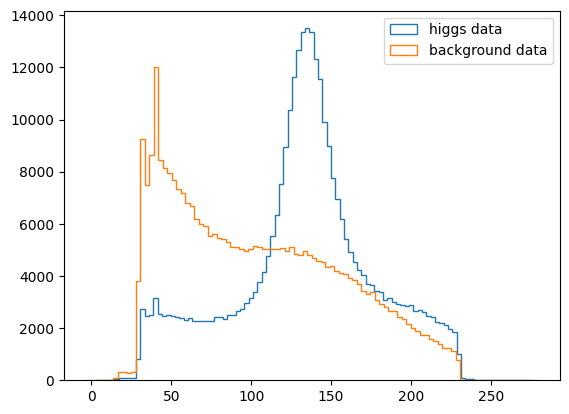

In [51]:
plt.hist( data_1.ak15_regressed_mass,bins=100,fill=False, histtype='step', label="higgs data")
plt.hist( data_2.ak15_regressed_mass[:n_max_1],bins=100, fill=False, histtype='step', label="background data")
plt.legend()

plt.draw()

In [78]:
data=Data()

random1=np.random.choice(n_max_1,n_max_1,replace=False) #inteiros ate o primeiro numero. Numero de eventos sorteados igual ao segundo numero
random2=np.random.choice(n_max_2,n_max_1,replace=False)
random_position=np.random.choice(2*n_max_1,n_max_1,replace=False)

is_here=np.zeros(n_max_1*2)
is_here[random_position] = 1


cont1=0
cont2=0

for cont in range(n_max_1*2):
    if is_here[cont]==0:
        data.ak15_regressed_mass.append(data_1.ak15_regressed_mass[random1[cont1]])
        data.truth.append(1)
        cont1=cont1+1
    if is_here[cont]==0:
        data.ak15_regressed_mass.append(data_2.ak15_regressed_mass[random2[cont2]])
        data.truth.append(0)
        cont2=cont2+1   




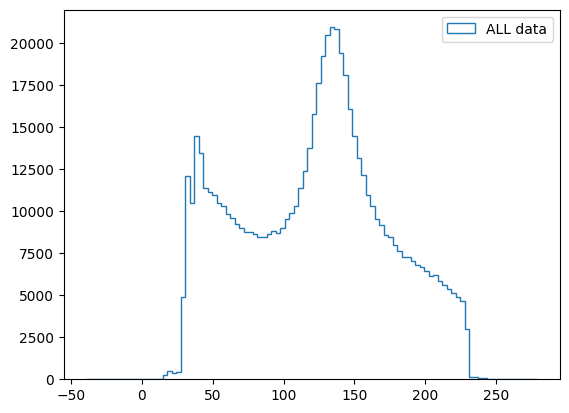

In [79]:
plt.hist( data.ak15_regressed_mass,bins=100, fill=False, histtype='step', label="ALL data")
plt.legend()
plt.draw()

In [99]:
from keras import models,layers,initializers

model= models.Sequential(name="my_neural")
model.add(layers.Input(shape=(1,)))
model.add(layers.Dense(8,activation="relu"))
model.add(layers.Dense(8,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])



In [100]:
#separando os dados
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(data.ak15_regressed_mass,data.truth,random_state=42)
x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)

In [101]:
model.summary()

Model: "my_neural"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

In [102]:
history = model.fit(x_train,y_train,epochs=100,batch_size=15000,validation_data=(x_test,y_test))

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5006 - loss: 27.0099 - val_accuracy: 0.4989 - val_loss: 10.1115
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5009 - loss: 5.6572 - val_accuracy: 0.4990 - val_loss: 1.1304
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5147 - loss: 0.8799 - val_accuracy: 0.5013 - val_loss: 0.6846
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5933 - loss: 0.6820 - val_accuracy: 0.6475 - val_loss: 0.6789
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6360 - loss: 0.6783 - val_accuracy: 0.6416 - val_loss: 0.6779
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6361 - loss: 0.6779 - val_accuracy: 0.6391 - val_loss: 0.6773
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6385 - loss: 0.6774 - val_accuracy: 0.6392 - val_loss: 0.6768
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6397 - loss: 0.6766 - val_accuracy: 

In [103]:
# Accessing the training loss history
training_loss = history.history['loss']

# Accessing the validation loss history
validation_loss = history.history['val_loss']

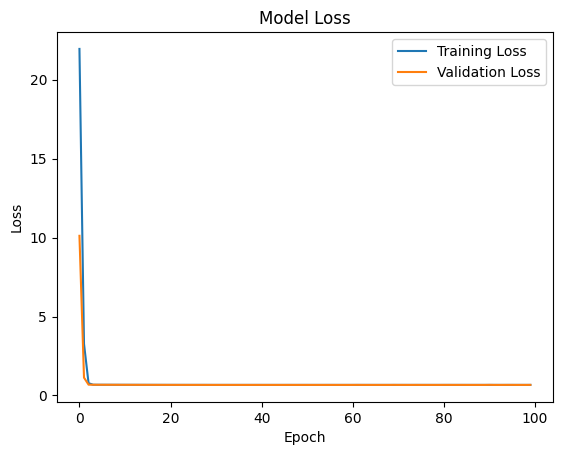

In [104]:
# Plot training & validation loss values
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [106]:
y_pred_prob = model.predict(x_test) 

5192/5192 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


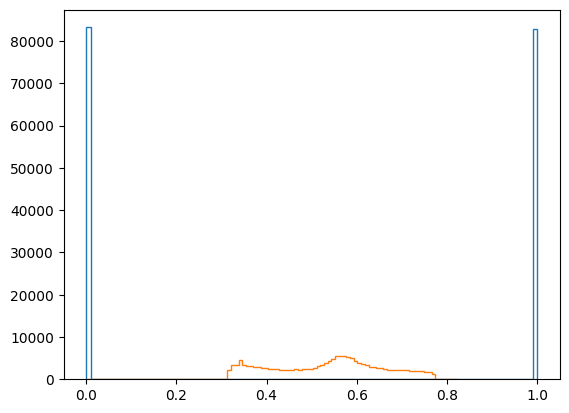

In [112]:
plt.hist(y_test, bins=100, fill=False, histtype='step', label="test data")
plt.hist(y_pred_prob,bins=100, fill=False, histtype='step', label="test data")


plt.show()

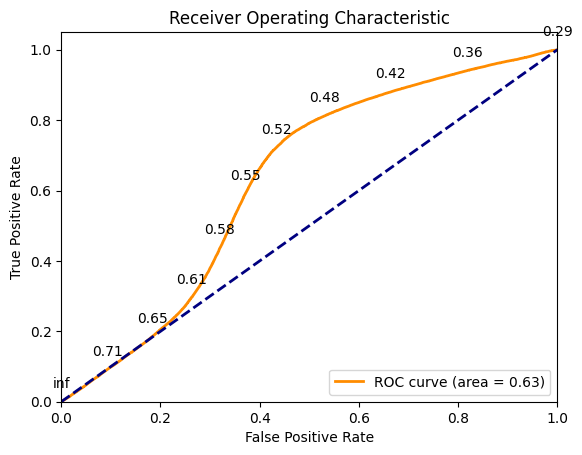

In [114]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Annotate some thresholds on the ROC curve
for i in range(0, len(thresholds), len(thresholds) // 10):
    plt.annotate(f'{thresholds[i]:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(0,10), ha='center')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()